In [1]:
from pysuffixarray.core import SuffixArray
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.setrecursionlimit(1000000)

# Задача № 0

Дорешайте задачу про риды и BWT из файла practice4.ipynb. В ответе помимо кода укажите количество ридов первой, второй и третьей категории, а также вкратце опишите ход решения.

Это домашнее задание можно выполнять целиком в этом ноутбуке, либо алгоритмы написать в отдельном файле и импортировать сюда, для использования. В папке data лежат два файла islands.fasta и nonIslands.fasta. В них хранятся прочтения из CpG островков и из обычных участков генома соответственно, этими данными нужно будет воспользоваться в первом задании.

In [2]:
class BTW_searcher():
    def __init__(self, sequence):

        self.suffix_array = SuffixArray(sequence)

        self.bwt_text = ''.join(sequence[i-1] if i != 0 else '$' for i in self.suffix_array.suffix_array())

        self.occ = {letter: [0 for _ in range(len(self.bwt_text))] for letter in '$ACGT'}

        for i, letter in enumerate(self.bwt_text):
            for ch in 'ACGT':
                if i != 0:
                    self.occ[ch][i] = self.occ[ch][i-1]
            if letter in self.occ.keys():
                self.occ[letter][i] += 1
    
        self.count = {}
        total = 0
        for letter in '$ACGT':
            self.count[letter] = total
            total += self.bwt_text.count(letter)

    def bwt_pattern_search(self, pattern):
        top = 0
        bottom = len(self.bwt_text) - 1
        for letter in reversed(pattern):
            if letter in self.occ:
                top = self.count[letter] + (0 if top == 0 else self.occ[letter][top-1])
                bottom = self.count[letter] + self.occ[letter][bottom] - 1
            else:
                return []
            if top > bottom:
                return []
        return self.suffix_array.suffix_array()[top:bottom+1]
    

def get_btw(seq):
    sa = SuffixArray(seq) 
    return ''.join(seq[i-1] if i != 0 else '$' for i in sa.suffix_array())


In [3]:
seqs = SeqIO.parse(r"/home/pk/Desktop/BioinformaticsCourse2024PK/homework/1_4/BWT_folder/genome.fa", "fasta")

for seq in seqs:
    sequence = str(seq.seq)

btw_text = get_btw(sequence)
bwts = BTW_searcher(sequence)

Риды без мутаций найти просто - нужно просто найти паттерн с помощью реализованного метода bwt_pattern_search. Если массив индексов непустой - вхождение подстроки есть

In [4]:
count = 0
with open(r"/home/pk/Desktop/BioinformaticsCourse2024PK/homework/1_4/BWT_folder/sample_reads.fasta", "r") as file:
    for record in SeqIO.parse(file, "fasta"):
        read_sequence = str(record.seq)
        pattern_insert = bwts.bwt_pattern_search(read_sequence)
        if len(pattern_insert) > 0:
            count += 1
            #  если надо вывести конкретные риды:
            #print("Processing read:", read_sequence)
            #print(*pattern_insert)
print('Число ридов без мутаций -', count)

Число ридов без мутаций - 45


Чтобы найти риды с несколькими мутациями (мы знаем их число - m), нужно разделить строку паттерн на (m+1) частей, и проверить, какая из них входит в последовательность (одна часть подстроки точно будет входить без ошибок в нашу строку). Если нашли вхождение - проверяем посимвольно соответствующие подстроку и часть строки. Если число несовпадающих символов равно числу m, то мы нашли подстроку в строке с заданным числом мутаций

In [5]:
def mutation_search(sequence, subsequence, num_mutations):
    i = 0
    k = len(subsequence)//(num_mutations+1)
    segments = []
    for _ in range(num_mutations):
        segments.append(subsequence[i:i+k])
        i += k
    segments.append(subsequence[i:])
    for segment_idx, segment in enumerate(segments):
            idxs = bwts.bwt_pattern_search(segment)
            for idx in idxs:
                start = idx-segment_idx*k
                end = start + len(subsequence)
                m = 0
                for char_idx in range(start, end):
                    if sequence[char_idx] != subsequence[char_idx-start]:
                        m += 1
                if m == num_mutations:
                    #  если надо вывести конкретные риды:
                    # print("Processing read:", subsequence)
                    # print(*pattern_insert)
                    return True
    return False

count_0 = 0
count_1 = 0
count_5 = 0
with open(r"/home/pk/Desktop/BioinformaticsCourse2024PK/homework/1_4/BWT_folder/sample_reads.fasta", "r") as file:
    for record in SeqIO.parse(file, "fasta"):
        subsequence = str(record.seq)
        if mutation_search(sequence, subsequence, 0):
            count_0 += 1
        if mutation_search(sequence, subsequence, 1):
            count_1 += 1
        if mutation_search(sequence, subsequence, 5):
            count_5 += 1

print('Число паттернов без мутаций -', count_0)
print('Число паттернов с одной мутацией -', count_1)
print('Число паттернов с пятью мутациями -', count_5)
print(count_0+count_1+count_5)

Число паттернов без мутаций - 45
Число паттернов с одной мутацией - 31
Число паттернов с пятью мутациями - 24
100


# Задача № 1
Определите частоты генерации для каждого из нуклеотидов внутри CpG островков и вне их. Посчитайте так-же частоты для всех упорядоченных пар нуклеотидов и сравните частоту пары CG внутри островков и снаружи. Сделайте вывод.

In [6]:
cpg_islands = list(SeqIO.parse(r"/home/pk/Desktop/BioinformaticsCourse2024PK/homework/1_4/data/islands.fasta", "fasta"))
non_cpg_islands = list(SeqIO.parse(r"/home/pk/Desktop/BioinformaticsCourse2024PK/homework/1_4/data/nonIslands.fasta", "fasta"))

In [7]:
def nucleotide_count(fasta_iterator):
    nucleotides = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    count = 0
    for sequence in fasta_iterator:
        count += len(sequence)
        sequence = str(sequence.seq)
        for nucleotide in sequence:
            nucleotides[nucleotide] += 1
    for nucleotide in nucleotides:
        nucleotides[nucleotide] /= count
    return nucleotides

def nucleotide_pairs_count(fasta_iterator):
    nucleotide_pairs = {'AA': 0, 'AC': 0, 'AG': 0, 'AT': 0,
                        'CA': 0, 'CC': 0, 'CG': 0, 'CT': 0,
                        'GA': 0, 'GC': 0, 'GG': 0, 'GT': 0, 
                        'TA': 0, 'TC': 0, 'TG': 0, 'TT': 0,
                        }
            
    count = 0
    for sequence in fasta_iterator:
        sequence = str(sequence.seq)
        for idx in range(len(sequence)-1):
            count += 1
            nucleotide_pair = sequence[idx:idx+2]
            nucleotide_pairs[nucleotide_pair] += 1
    for nucleotide_pair in nucleotide_pairs:
        nucleotide_pairs[nucleotide_pair] /= count
    return nucleotide_pairs



In [8]:
print('Частота нуклеотидов в CpG-островках:')
islands_nucleotides = list("%.4f" % member for member in nucleotide_count(cpg_islands).values())
print('  A\t', '  C\t', '  G\t', '  T\t')
print(*islands_nucleotides, sep='  ')
print('---------------------------------------')
print('Частота нуклеотидов не в CpG-островках:')
non_islands_nucleotides = list("%.4f" % member for member in nucleotide_count(non_cpg_islands).values())
print('  A\t', '  C\t', '  G\t', '  T\t')
print(*non_islands_nucleotides, sep='  ')

Частота нуклеотидов в CpG-островках:


  A	   C	   G	   T	
0.2025  0.2964  0.2983  0.2029
---------------------------------------
Частота нуклеотидов не в CpG-островках:
  A	   C	   G	   T	
0.2893  0.1961  0.1984  0.3161


In [9]:
print('Частота пар нуклеотидов в CpG-островках:')
print('\t', 'A\t', 'C\t', 'G\t', 'T\t')
islands_pairs = list("%.4f" % member for member in nucleotide_pairs_count(cpg_islands).values())
print('   A', *islands_pairs[:4], sep='  ')
print('   C', *islands_pairs[4:8], sep='  ')
print('   G', *islands_pairs[8:12], sep='  ')
print('   T', *islands_pairs[12:], sep='  ')
print('------------------------------------------')
print('Частота пар нуклеотидов не в CpG-островках:')
print('\t', 'A\t', 'C\t', 'G\t', 'T\t')
not_islands_pairs = list("%.4f" % member for member in nucleotide_pairs_count(non_cpg_islands).values())
print('   A', *not_islands_pairs[:4], sep='  ')
print('   C', *not_islands_pairs[4:8], sep='  ')
print('   G', *not_islands_pairs[8:12], sep='  ')
print('   T', *not_islands_pairs[12:], sep='  ')

Частота пар нуклеотидов в CpG-островках:
	 A	 C	 G	 T	
   A  0.0512  0.0459  0.0719  0.0334
   C  0.0629  0.1028  0.0590  0.0717
   G  0.0599  0.0882  0.1036  0.0467
   T  0.0285  0.0595  0.0638  0.0510
------------------------------------------
Частота пар нуклеотидов не в CpG-островках:
	 A	 C	 G	 T	
   A  0.0899  0.0471  0.0702  0.0821
   C  0.0682  0.0500  0.0053  0.0727
   G  0.0602  0.0342  0.0501  0.0539
   T  0.0710  0.0648  0.0729  0.1075


Видно, что содержание C в CpG-островах выше (а T ниже), так как в этих областях подавляется метилирование C </br>
Также видно, насколько больше CG в CpG-островках (0.059 против 0.0053 - разница практически в 11 раз)

# Задача № 2
Напишите марковскую модель, которая имеет открытые состояния {A, T, G, C}, и скрытые состояния {+, -}. Когда модель в состоянии +, то вероятность генерации некоторого символа нуклеотида соответствует его частоте внутри CpG островков, вычислиному в первом задании, если состояние -, то частоте вне островков. Вероятность остаться внутри островка 0.95, а перейти в обычный геном 0.05. Для остальной части генома соответствующие вероятности 0.995 и 0.005. Саму модель можно реализовать в виде итератора, определив метод next, который возвращает пару - состояние и нуклеотид, который в этом состоянии произведен.</br>
Воспользуйтесь данной моделью для того чтобы сгенерировать набор из 20 последовательностей длинной от 1 000 до 100 000, причем к каждой последовательности должна прилагаться последовательность состояний.

In [10]:
class cpg_HMM:
    def __init__(self, sequence_len):
        self.sequence_len = sequence_len
        self.current_len = 0
        self.cpg_nucleotides = [0.203, 0.296, 0.298, 0.203]  # A C G T
        self.not_cpg_nucleotides = [0.290, 0.196, 0.198, 0.316]  # A C G T
        self.cpg_next = [0.95, 0.05]  # stay move
        self.not_cpg_next = [0.995, 0.005]  # stay move
        self.current_state = np.random.choice(['+', '-'], p=[0.5, 0.5])

    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_len < self.sequence_len:
            self.current_len += 1
            if self.current_state == '+':
                nucleotide = np.random.choice(['A', 'C', 'G', 'T'], p=self.cpg_nucleotides)
                next_state = np.random.choice(['+', '-'], p=self.cpg_next)
            elif self.current_state == '-':
                nucleotide = np.random.choice(['A', 'C', 'G', 'T'], p=self.not_cpg_nucleotides)
                next_state = np.random.choice(['-', '+'], p=self.not_cpg_next)
            current_pair = (nucleotide, self.current_state)
            self.current_state = next_state
            return current_pair   
        else:
            raise StopIteration

def sequence_output(sequence_len):
    sequence = []
    states = []
    sequence_iterator = cpg_HMM(sequence_len)
    for i in sequence_iterator:
        sequence.append(i[0])
        states.append(i[1])
    return sequence, states

In [ ]:
all_sequences = []
all_states = []
for sequence_len in range(1000, 104950, 4950):
    sequence, states = sequence_output(sequence_len)
    all_sequences.append(sequence)
    all_states.append(states)
    # print(*sequence, sep='')
    # print(*states, sep='')

# Задача № 3
Напишите алгоритм Витерби для восстановления последовательности скрытых состояний марковской модели из второго задания. Воспользуйтесь им, воссстановив состояния тех последовательностей, которые вы получили во втором задании и посчитайте TP, TN, FP, FN по количеству правильно или ошибочно предсказанных позиций из CpG островков. 

In [12]:
def viterbi(sequence, transition_matrix, observation_matrix):
    numbering = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequence_len = len(sequence)
    p_current_state = np.full((2, sequence_len), -np.inf).astype('float128')
    prev_state = np.zeros((2, sequence_len)).astype('int')
    
    for j in range(2):
        p_current_state[j][0] = np.log(0.5*observation_matrix[j][numbering[sequence[0]]])

    for i in range(1, sequence_len):
        current_char = numbering[sequence[i]]
        for j in range(2):
            for k in range(2):
                next_state = p_current_state[k][i-1] + np.log(transition_matrix[k][j]) + np.log(observation_matrix[j][current_char])
                if next_state > p_current_state[j][i]:
                    prev_state[j][i] = k
                    p_current_state[j][i] = next_state
            
    k = np.argmax(p_current_state, axis=1)[-1]
    answer = np.zeros((sequence_len)).astype('int')
    answer[-1] = k
    for i in range(sequence_len-1, 2, -1):
        answer[i-1] = prev_state[answer[i], i]
    return answer



def show_metrics_viterbi(sequence, states):
    transition_matrix = np.array([[0.95, 0.05], [0.005, 0.995]])  # + -
    observation_matrix = np.array([[0.203, 0.296, 0.298, 0.203], [0.290, 0.196, 0.198, 0.316]])  # A C G T
    predicted = viterbi(sequence, transition_matrix, observation_matrix)
    # print(predicted)
    # print(*states)
    #  positive - CpG, negative - notCpG
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(sequence)):
        if predicted[i] == 0 and states[i] == '+':
            TP += 1
        elif predicted[i] == 1 and states[i] == '-':
            TN += 1
        elif predicted[i] == 0 and states[i] == '-':
            FP += 1
        elif predicted[i] == 1 and states[i] == '+':
            FN += 1
    print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN, {FN}')
    # if TP != 0 or FP != 0:
    #     print('precision', TP/(TP+FP))
    # if TP != 0 or FN != 0:
    #     print('recall', TP/(TP+FN))
    # print('accuracy', (TP+TN)/(TP+TN+FP+FN))

In [13]:
for sequence, states in zip(all_sequences, all_states):
    print('length:', len(sequence))
    show_metrics_viterbi(sequence, states)
    print()

length: 1000
TP: 0, TN: 922, FP: 15, FN, 63

length: 5950
TP: 2, TN: 5506, FP: 3, FN, 439

length: 10900
TP: 0, TN: 9551, FP: 3, FN, 1346

length: 15850
TP: 93, TN: 14130, FP: 10, FN, 1617

length: 20800
TP: 248, TN: 18400, FP: 122, FN, 2030

length: 25750
TP: 66, TN: 23225, FP: 53, FN, 2406

length: 30700
TP: 266, TN: 27580, FP: 59, FN, 2795

length: 35650
TP: 150, TN: 32898, FP: 20, FN, 2582

length: 40600
TP: 0, TN: 36778, FP: 19, FN, 3803

length: 45550
TP: 284, TN: 41135, FP: 84, FN, 4047

length: 50500
TP: 43, TN: 46095, FP: 3, FN, 4359

length: 55450
TP: 81, TN: 50817, FP: 39, FN, 4513

length: 60400
TP: 123, TN: 54483, FP: 59, FN, 5735

length: 65350
TP: 368, TN: 59321, FP: 52, FN, 5609

length: 70300
TP: 190, TN: 63873, FP: 8, FN, 6229

length: 75250
TP: 100, TN: 68884, FP: 23, FN, 6243

length: 80200
TP: 265, TN: 72924, FP: 136, FN, 6875

length: 85150
TP: 724, TN: 77271, FP: 118, FN, 7037

length: 90100
TP: 666, TN: 82025, FP: 222, FN, 7187

length: 95050
TP: 338, TN: 86499,

# Задача № 4
Напишите алгоритм вперед назад для модели из второго задания. Пользуясь этим алгоритмом найдите вероятности того, что модель находилась в состоянии + для каждой позиции строк из второго задания. Устанавливая различные пороговые значения, определите позиции соответствующие CpG островкам и посчитайте TP. Постройте график зависимости TP от выбранного порогового значения. Есть ли пороговые значения при которых TP больше чем в задании №3?

In [14]:
class forward_backward_algo():
    def __init__(self, sequence):
        self.sequence_len = len(sequence)
        self.forward = np.zeros((2, self.sequence_len)).astype('float128')
        self.backward = np.zeros((2, self.sequence_len)).astype('float128')
        self.transition_matrix = np.array([[0.95, 0.05], [0.005, 0.995]])  # + -
        self.observation_matrix = np.array([[0.203, 0.296, 0.298, 0.203], [0.290, 0.196, 0.198, 0.316]])  # A C G T
        self.numbering = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        self.probas = np.zeros((2, self.sequence_len))
        self.predicted_states = np.array([None for _ in range(self.probas.shape[1])])

    def _alpha(self, s, t):
        if self.forward[s][t]:
            return self.forward[s][t]
        fwd = 0
        for state in range(2):
            fwd += self._alpha(state, t-1) * self.transition_matrix[state][s]
        fwd *= self.observation_matrix[s][self.numbering[sequence[t]]]
        self.forward[s][t] = fwd
        return self.forward[s][t]

    def _beta(self, s, t):
        if self.backward[s][t]:
            return self.backward[s][t]
        bkw = 0
        for state in range(2):
            bkw += self._beta(state, t+1) * self.transition_matrix[s][state] * self.observation_matrix[state][self.numbering[sequence[t+1]]]
        self.backward[s][t] = bkw
        return self.backward[s][t]

    def get_probas(self):
        for state in range(2):
            self.forward[state][0] = self.observation_matrix[state][self.numbering[sequence[0]]] * 0.5
            self.backward[state][self.sequence_len-1] = 1
            chain_proba = 0
        for t in range(len(sequence)):
            chain_proba = 0
            for state in range(2):
                chain_proba += self._alpha(state, t) * self._beta(state, t)
            for s in range(2):
                self.probas[s][t] = (self._alpha(s, t) * self._beta(s, t))/chain_proba
        return self.probas
    
    def get_states(self, threshold=0.5):
        if not self.probas.all():
            self.probas = self.get_probas()
        for p_idx in range(self.probas.shape[1]):
            p = self.probas[0][p_idx]
            if p > threshold:
                self.predicted_states[p_idx] = 0
            else:
                self.predicted_states[p_idx] = 1
        return self.predicted_states
    
    def TP_calc(self, states, threshold=0.5):
        self.predicted_states = self.get_states(threshold)
        TP = 0
        for i in range(len(sequence)):
            if self.predicted_states[i] == 0 and states[i] == '+':
                TP += 1
        return TP


In [15]:
sequence, states = sequence_output(5000)
alg = forward_backward_algo(sequence)
print(alg.get_probas())

thresholds = []
TPs = []

for threshold in range(0, 101, 1):
    threshold /= 100
    thresholds.append(threshold)
    TPs.append(alg.TP_calc(states, threshold))

[[0.23215377 0.20912066 0.19492262 ... 0.05022196 0.05208522 0.05744067]
 [0.76784623 0.79087934 0.80507738 ... 0.94977804 0.94791478 0.94255933]]


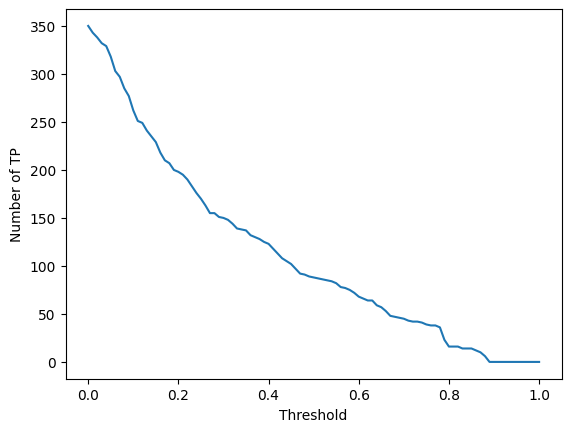

In [16]:
plt.plot(thresholds, TPs)
plt.xlabel("Threshold")
plt.ylabel("Number of TP")

plt.show()